<a href="https://colab.research.google.com/github/rodrigo-koblitz/Caged_data/blob/main/caged_data_speedup2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A informação dos empregos formais no Brasil são fontes de inúmeras análises. Aqui pretendemos demonstrar uma forma de extração e apresentação desses dados. 
Para obter os dados faz-se necessário baixar as planilhas mês a mês no site do sistema do CAGED. Cada planilha tem um tamanho entre 8 e 22 MB. Portanto, o processo pode ser um pouco lento. A cada planilha lida voce poderá ver essa informação.
Criaremos inicialmente um DataFrame pandas e depois uma visualização simples dos dados.

Para facilitar o uso do mês em portugues, conforme é apresentado no CAGED, instalamos o 'language-pack pt_BR' no Colab.

In [ ]:
import os
!/usr/share/locales/install-language-pack pt_BR
!dpkg-reconfigure locales
os.kill(os.getpid(), 9)


Generating locales (this might take a while)...
  pt_BR.ISO-8859-1... done
Generation complete.
dpkg-trigger: error: must be called from a maintainer script (or with a --by-package option)

Type dpkg-trigger --help for help about this utility.
Generating locales (this might take a while)...
  en_US.UTF-8... done
  pt_BR.ISO-8859-1... done
Generation complete.


In [1]:
import io
from openpyxl import load_workbook
import datetime #import datetime
import pandas as pd
import os
import locale
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import requests
import time
import openpyxl
from io import BytesIO
import concurrent.futures
import threading
import time
import asyncio
import aiohttp
def range_month(dt_ini=None,dt_fim=None):
 if not dt_fim:
  dt_fim=datetime.datetime.now()
 if not dt_ini:
  dt_ini='122019'
 lt_alltime=pd.date_range(datetime.datetime.strptime(dt_ini, "%m%Y") - datetime.timedelta(days=10),
                          dt_fim, freq='MS')
 t_lim=datetime.datetime.strptime('122019','%m%Y')
 lt_before=[i for i in lt_alltime if i <= t_lim]
 lt_after=[i for i in lt_alltime if i > t_lim]
 return lt_before,lt_after
def get_links(dt_ini=None,dt_fim=None):
 lt_before,lt_after=range_month(dt_ini,dt_fim)
 links_before=['ftp://ftp.mtps.gov.br/pdet/caged/%s/%s/nacionais/4-tabelas.xls'\
          %(i.strftime('%Y'),i.strftime('%B').replace('ç','c')) for i in lt_before]
 links_after=['http://pdet.mte.gov.br/images/Novo_CAGED/%s/3-tabelas.xlsx'\
          %i.strftime('%b%Y').capitalize() for i in lt_after]
 #return links_before+links_after
 return links_after
def get_from_worksheet1(wd,muni,mesano):
  #wd=pd.DataFrame(ws.values)
  row=wd.loc[wd.iloc[:,2]==muni].values[0]
  municipio=row[3]
  saldo=row[6]
  admissoes=row[4]
  desligamentos=row[5]
  var_relativa=row[7]
  mes_anots=datetime.datetime.strptime(mesano[:7], "%b%Y")
  return [municipio, saldo, admissoes, desligamentos, var_relativa, mesano, mes_anots]

In [ ]:
def download_ulr(url, municipios,session):
  #session=requests.Session()
  with session.get(url) as r:
   with io.BytesIO(r.content) as sheet:
    try:
      dfg=pd.io.excel.read_excel(sheet, sheet_name=sheet_nameN)
    except:
      dfg=None
    return dfg
def processing_df(url,municipios,session,columns):
  print('processing: %s'%url)
  all_values=[]
  mesano="%s"%url.split('/')[5]
  if type(municipios)!=list:
    municipios=[municipios]
  df=download_ulr(url, municipios,session)
  if df is None:
    return None
  for muni in municipios:
    values=get_from_worksheet1(df,muni,mesano)
    all_values.append(values)
  print('url processed')
  return pd.DataFrame(all_values, columns=columns)

def get_all_urls(urls, municipios,df1):
  dfs=[]
  if type(urls)!=list:
    urls=[urls]
  with requests.Session() as session:
   for url in urls:
    dft=processing_df(url,municipios,session, df1.columns)
    if dft is None:
      return None
    dfs.append(pd.DataFrame(dft))
  return pd.concat(dfs,ignore_index=True)
if __name__=='__main__':
 sheet_nameN='Tabela 3'
 columnsN=['municipio','admissoes', 'desligamentos', 'saldo', 'var_relativa', 'mes_ano', 'mes_anots']
 df1=pd.DataFrame(columns=columnsN)
 links=get_links()
 municipios=[330340, 330390,330580]
 urls=links
 start_time = time.time()
 #  for url in links[:3]:
 #   df1=add_in_df(url,municipios,df1)
 df2=get_all_urls(urls, municipios,df1)
 duration = time.time() - start_time
 print(f"Downloaded {len(urls)} in {duration} seconds")

processing: http://pdet.mte.gov.br/images/Novo_CAGED/Jan2020/3-tabelas.xlsx


/usr/local/lib/python3.8/dist-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


url processed
processing: http://pdet.mte.gov.br/images/Novo_CAGED/Fev2020/3-tabelas.xlsx
url processed
processing: http://pdet.mte.gov.br/images/Novo_CAGED/Mar2020/3-tabelas.xlsx
url processed
processing: http://pdet.mte.gov.br/images/Novo_CAGED/Abr2020/3-tabelas.xlsx
url processed
processing: http://pdet.mte.gov.br/images/Novo_CAGED/Mai2020/3-tabelas.xlsx
url processed
processing: http://pdet.mte.gov.br/images/Novo_CAGED/Jun2020/3-tabelas.xlsx
url processed
processing: http://pdet.mte.gov.br/images/Novo_CAGED/Jul2020/3-tabelas.xlsx
url processed
processing: http://pdet.mte.gov.br/images/Novo_CAGED/Ago2020/3-tabelas.xlsx
url processed
processing: http://pdet.mte.gov.br/images/Novo_CAGED/Set2020/3-tabelas.xlsx
url processed
processing: http://pdet.mte.gov.br/images/Novo_CAGED/Out2020/3-tabelas.xlsx
url processed
processing: http://pdet.mte.gov.br/images/Novo_CAGED/Nov2020/3-tabelas.xlsx
url processed
processing: http://pdet.mte.gov.br/images/Novo_CAGED/Dez2020/3-tabelas.xlsx
url proces

Now, let's use the threading strategy

In [ ]:
def download_ulr(url, municipios,session):
  #session=requests.Session()
  with session.get(url) as r:
   with io.BytesIO(r.content) as sheet:
     try:
       dfg=pd.io.excel.read_excel(sheet, sheet_name=sheet_nameN)
     except:
       dfg=None
     return dfg
def processing_df(url,municipios,session, columns):
  all_values=[]
  mesano="%s"%url.split('/')[5]
  df=download_ulr(url, municipios,session)
  if df is None:
    return None
  if type(municipios)!=list:
    municipios=[municipios]
  for muni in municipios:
   all_values.append(get_from_worksheet1(df,muni,mesano))
  return pd.DataFrame(all_values, columns=columns)
def get_all_urls(urls, municipios, df1):
  dfs = []
  if type(urls) != list:
    urls = [urls]
  columns = df1.columns
  with requests.Session() as session:
    with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
      futures = []
      for url in urls:
        print(url)
        futures.append(executor.submit(processing_df, url, municipios, session, columns))

        # with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
        # executor.map(download_site, sites)


      for future in concurrent.futures.as_completed(futures):
        dft = future.result()
        if dft is not None:
          dfs.append(dft)
  return pd.concat(dfs, ignore_index=True)
if __name__=='__main__':
 sheet_nameN='Tabela 3'
 columnsN=['municipio','admissoes', 'desligamentos', 'saldo', 'var_relativa', 'mes_ano', 'mes_anots']
 df1=pd.DataFrame(columns=columnsN)
 links=get_links()
 municipios=[330340, 330390,330580]
 urls=links
 start_time = time.time()
 #  for url in links[:3]:
 #   df1=add_in_df(url,municipios,df1)
 df2=get_all_urls(urls, municipios,df1)
 duration = time.time() - start_time
 print(f"Downloaded {len(urls)} in {duration} seconds")

http://pdet.mte.gov.br/images/Novo_CAGED/Jan2020/3-tabelas.xlsx
http://pdet.mte.gov.br/images/Novo_CAGED/Fev2020/3-tabelas.xlsx
http://pdet.mte.gov.br/images/Novo_CAGED/Mar2020/3-tabelas.xlsx
http://pdet.mte.gov.br/images/Novo_CAGED/Abr2020/3-tabelas.xlsx
http://pdet.mte.gov.br/images/Novo_CAGED/Mai2020/3-tabelas.xlsx
http://pdet.mte.gov.br/images/Novo_CAGED/Jun2020/3-tabelas.xlsx
http://pdet.mte.gov.br/images/Novo_CAGED/Jul2020/3-tabelas.xlsx
http://pdet.mte.gov.br/images/Novo_CAGED/Ago2020/3-tabelas.xlsx
http://pdet.mte.gov.br/images/Novo_CAGED/Set2020/3-tabelas.xlsx
http://pdet.mte.gov.br/images/Novo_CAGED/Out2020/3-tabelas.xlsx
http://pdet.mte.gov.br/images/Novo_CAGED/Nov2020/3-tabelas.xlsx
http://pdet.mte.gov.br/images/Novo_CAGED/Dez2020/3-tabelas.xlsx
http://pdet.mte.gov.br/images/Novo_CAGED/Jan2021/3-tabelas.xlsx
http://pdet.mte.gov.br/images/Novo_CAGED/Fev2021/3-tabelas.xlsx
http://pdet.mte.gov.br/images/Novo_CAGED/Mar2021/3-tabelas.xlsx
http://pdet.mte.gov.br/images/Novo_CAGED

/usr/local/lib/python3.8/dist-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


Downloaded 38 in 91.82796049118042 seconds


Now we test asyncio 

In [ ]:
async def download_ulr(url, municipios,session):
  #session=requests.Session()
  async with session.get(url) as r:
   with io.BytesIO(r.content) as sheet:
    if sheet is not None:
      return await pd.io.excel.read_excel(sheet, sheet_name=sheet_nameN)
    else:
      return None

def processing_df(url,municipios,session,columns):
  print('processing: %s'%url)
  all_values=[]
  mesano="%s"%url.split('/')[5]
  if type(municipios)!=list:
    municipios=[municipios]
  df=download_ulr(url, municipios,session)
  if df is None:
    return None
  for muni in municipios:
    values=get_from_worksheet1(df,muni,mesano)
    all_values.append(values)
  print('url processed')
  return pd.DataFrame(all_values, columns=columns)
async def download_all_sites(sites):
    async with aiohttp.ClientSession() as session:
        tasks = []
        for url in sites:
            task = asyncio.ensure_future(download_site(session, url))
            tasks.append(task)
        await asyncio.gather(*tasks, return_exceptions=True)
async def get_all_urls(urls, municipios,df1):
  if type(urls)!=list:
    urls=[urls]
  async with aiohttp.ClientSession() as session:
    dfs=[]
    for url in urls:
      task = asyncio.ensure_future(processing_df(url,municipios,session, df1.columns))
      tasks.append(task)
    results = await asyncio.gather(*tasks)
    for data in results:
      if data is not None:
        df = pd.read_html(data)[0]
        dfs.append(df)
  return pd.concat(dfs,ignore_index=True)

if __name__=='__main__':
 sheet_nameN='Tabela 3'
 columnsN=['municipio','admissoes', 'desligamentos', 'saldo', 'var_relativa', 'mes_ano', 'mes_anots']
 df1=pd.DataFrame(columns=columnsN)
 links=get_links()
 municipios=[330340, 330390,330580]
 urls=links
 start_time = time.time()
 #  for url in links[:3]:
 #   df1=add_in_df(url,municipios,df1)
 df2 =asyncio.get_event_loop().run_until_complete((get_all_urls(urls, municipios,df1)))
 #df2 = asyncio.run((get_all_urls(urls, municipios,df1)))
 duration = time.time() - start_time
 print(f"Downloaded {len(urls)} in {duration} seconds")



RuntimeError: ignored

In [2]:
async def fetch(url):
    async with aiohttp.ClientSession() as session:
        async with session.get(url) as response:
            return await response.text()

async def main():
    urls = ['https://www.example.com', 'https://www.google.com', 'https://www.python.org']
    tasks = []
    for url in urls:
        tasks.append(asyncio.create_task(fetch(url)))
    results = await asyncio.gather(*tasks)
    print(results)

loop = asyncio.get_event_loop()
loop.run_until_complete(main())


RuntimeError: ignored

In [ ]:
try:
    loop = asyncio.get_running_loop()
    print(f"An event loop is already running: {loop}")
except RuntimeError:
    print("No event loop is running")

An event loop is already running: <_UnixSelectorEventLoop running=True closed=False debug=False>


In [ ]:
async def my_coroutine():
    # This coroutine will run indefinitely until the event loop is stopped
    while True:
        print("Waiting for 1 second...")
        await asyncio.sleep(1)

# Start the event loop and run the coroutine
loop = asyncio.get_event_loop()
task = loop.create_task(my_coroutine())

# ...do other stuff...

# Stop the event loop
loop.stop()

# Wait for the coroutine to finish
try:
    loop.run_until_complete(task)
except asyncio.CancelledError:
    pass

RuntimeError: ignored

In [ ]:
async def my_coroutine():
    # This coroutine will run indefinitely until the event loop is stopped
    while True:
        print("Waiting for 1 second...")
        await asyncio.sleep(1)

# Start the event loop and run the coroutine
loop = asyncio.get_event_loop()
task = loop.create_task(my_coroutine())

# ...do other stuff...

# Stop the event loop
loop.call_soon_threadsafe(loop.stop)

# Wait for the coroutine to finish
try:
    loop.run_until_complete(task)
except asyncio.CancelledError:
    pass


NameError: ignored

Selcionamos os município de Petrópolis, Nova Frburgo e Teresópolis para essa análise desde o início do novo CAGED.

In [ ]:
municipios=[330340, 330390,330580]

In [ ]:
df1=create_df(municipios,'012020')

Esse programa sequencialmente demorou xxx minutos para se completar. Vamos testar agora com diferentes processos concorrentes. Multiprocessing e multi threding para otimizá-lo e identificar qual o mais rápido. Como esse é um problema de IO bound, a limitação não é da CPU, que fica parada muito tempo, mas uma restrição de rede, a multitrheading deve ser a melhor opção. 
Começamos por pegar os links a serem baixados.

In [ ]:
links=get_links('012020')

In [ ]:
links

In [ ]:
df1

municipio saldo   ano  mes  mes_ano  mes_anots
1    Rj-Nova Friburgo   -97  2020  Jan  Jan2020 2020-01-01
2       Rj-Petropolis  -177  2020  Jan  Jan2020 2020-01-01
3      Rj-Teresopolis    43  2020  Jan  Jan2020 2020-01-01
4    Rj-Nova Friburgo   220  2020  Fev  Fev2020 2020-02-01
5       Rj-Petropolis   300  2020  Fev  Fev2020 2020-02-01
..                ...   ...   ...  ...      ...        ...
98      Rj-Petropolis   396  2022  Set  Set2022 2022-09-01
99     Rj-Teresopolis    33  2022  Set  Set2022 2022-09-01
100  Rj-Nova Friburgo   103  2022  Out  Out2022 2022-10-01
101     Rj-Petropolis   203  2022  Out  Out2022 2022-10-01
102    Rj-Teresopolis     6  2022  Out  Out2022 2022-10-01

[102 rows x 6 columns]

Para fazer o download do dataframe df1 que contém toda a informação obtida:

In [ ]:
from google.colab import files
df1.to_csv('df1.csv')
files.download("df1.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df1

municipio saldo   ano  mes  mes_ano  mes_anots
1    Rj-Nova Friburgo   -97  2020  Jan  Jan2020 2020-01-01
2       Rj-Petropolis  -177  2020  Jan  Jan2020 2020-01-01
3      Rj-Teresopolis    43  2020  Jan  Jan2020 2020-01-01
4    Rj-Nova Friburgo   220  2020  Fev  Fev2020 2020-02-01
5       Rj-Petropolis   300  2020  Fev  Fev2020 2020-02-01
..                ...   ...   ...  ...      ...        ...
98      Rj-Petropolis   396  2022  Set  Set2022 2022-09-01
99     Rj-Teresopolis    33  2022  Set  Set2022 2022-09-01
100  Rj-Nova Friburgo   103  2022  Out  Out2022 2022-10-01
101     Rj-Petropolis   203  2022  Out  Out2022 2022-10-01
102    Rj-Teresopolis     6  2022  Out  Out2022 2022-10-01

[102 rows x 6 columns]

Uma opção de visualização

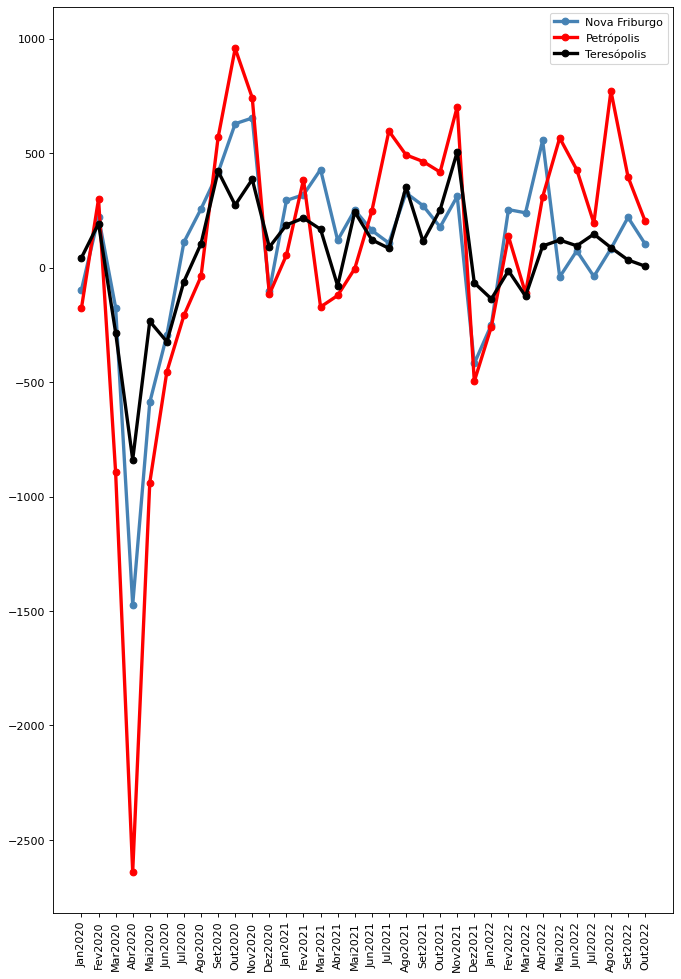

In [ ]:
figure(figsize=(10, 15), dpi=80)
col1 = 'steelblue'
d1=df1.loc[df1.municipio=='Rj-Nova Friburgo']
col2 = 'red'
d2=df1.loc[df1.municipio=='Rj-Petropolis']
col3='black'
d3=df1.loc[df1.municipio=='Rj-Teresopolis']
plt.plot(d1.mes_ano, d1.saldo, color=col1, marker='o', linewidth=3,
         label='Nova Friburgo')
plt.xticks(rotation=90)
plt.plot(d2.mes_ano, d2.saldo, color=col2, marker='o', linewidth=3,
         label='Petrópolis')
plt.plot(d3.mes_ano, d3.saldo, color=col3, marker='o', linewidth=3,
         label='Teresópolis')
plt.legend()#loc="upper left")

Bom trabalho com suas análises! 